In [314]:
import requests
import json
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



ziskanie dát z api

In [315]:
def unix_to_datetime(unix_timestamp):
    import datetime

    # konverzia unix timestamp na sekundy
    timestamp_sec = unix_timestamp / 1000
    dt_object = datetime.datetime.fromtimestamp(timestamp_sec)

    # konverzia objektu datetime na string
    formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')

    # konverzia stringu na datetime
    formatted_date = pd.to_datetime(formatted_date)

    return formatted_date


In [316]:
# funkcia na normalizovanie ziskanych dat z API

def normalize_data(data):

    df_3_attributes = pd.json_normalize(data)

    df_of_data=pd.json_normalize(data['data'])  # vnorene data

    wax_to_usd_rate = 0.0643    # približny kurz WAX na USD

    for i in range(0, len(df_of_data)):
        get_wax = 10 ** df_of_data['price.token_precision'][i]
        df_of_data.loc[i, 'updated_at_time'] = unix_to_datetime(int(df_of_data['updated_at_time'][i]))
        df_of_data.loc[i, 'created_at_time'] = unix_to_datetime(int(df_of_data['created_at_time'][i]))
        df_of_data.loc[i, 'price_wax'] = round(float(df_of_data['price.amount'][i])/ get_wax, 5)
        df_of_data.loc[i, 'price_usd'] = round((float(df_of_data['price.amount'][i]) / get_wax) * wax_to_usd_rate, 5)

    for index, row in df_of_data.iterrows():
        for asset in row['assets']:
            asset["sale_id"] = row['sale_id']     
            for price in asset['prices']:
                price["sale_id"] = row['sale_id']

    # normalizacia vnorenych dat
    df_of_nested_assets = pd.json_normalize(data['data'], record_path=['assets'])

    # spracovanie stlpcov s časom
    datetime_columns = df_of_nested_assets.columns[df_of_nested_assets.columns.str.contains('time')].tolist()
    for i in range(0, len(df_of_nested_assets)):
        for column in datetime_columns:
            if df_of_nested_assets[column][i] is not None:
                df_of_nested_assets.loc[i, column] = unix_to_datetime(int(df_of_nested_assets[column][i]))
            else:
                df_of_nested_assets.loc[i, column] = pd.NaT

    # normalizacia vnorenych dat
    normalized_dataframes = []
    for index, row in df_of_nested_assets.iterrows():
        normalized_data = pd.json_normalize(row['prices'])
        normalized_dataframes.append(normalized_data)
    df_of_nested_prices_2 = pd.concat(normalized_dataframes, ignore_index=True)

    # odstranenie nepotrebnych stlpcov
    df_of_data.drop(columns=['assets'], inplace=True)
    df_of_nested_assets.drop(columns=['prices'], inplace=True)

    return df_3_attributes, df_of_data, df_of_nested_assets, df_of_nested_prices_2


In [317]:
# definicia URL a parametrov pre api GET request
url = "https://wax.api.atomicassets.io/atomicmarket/v2/sales"

# vytvorenie datovych ramcov pre ukladanie dat
df_3_attributes_all=pd.DataFrame()
df_of_data_all=pd.DataFrame()
df_of_nested_assets_all=pd.DataFrame()
df_of_nested_prices_all=pd.DataFrame()
df_of_nested_prices_2_all=pd.DataFrame()

# použite cyklu na získanie 5 stránok údajov
for i in range(1, 6):
    params = {
        "state": "3", #3-sold
        "collection_name": "farmersworld",
        "template_id": "298593",
        "page": i,
        #"before": "",  epoch timestamp
        #"after": "",
        "limit": "100",
        "order": "desc",
        "sort": "updated",
    }
    headers = {
        "accept": "application/json",
    }

    # GET request
    response = requests.get(url, params=params, headers=headers)

    # Request
    if response.status_code == 200:
        
        data = response.json()

        # ulož json dáta do súboru
        with open(f'data_{i}.json', 'w') as f:
            json.dump(data, f, indent=2)

        # funkcia na načítanie json dát a uloženie ich všetkých do premenných
        df_1, df_2, df_3, df_4 = normalize_data(data)

        # spoj všetky datove ramce
        if i == 1:
            df_3_attributes_all = df_1
            df_of_data_all = df_2
            df_of_nested_assets_all = df_3
            df_of_nested_prices_all = df_4
        else:
            df_3_attributes_all = pd.concat([df_3_attributes_all, df_1], ignore_index=True)
            df_of_data_all = pd.concat([df_of_data_all, df_2], ignore_index=True)
            df_of_nested_assets_all = pd.concat([df_of_nested_assets_all, df_3], ignore_index=True)
            df_of_nested_prices_all = pd.concat([df_of_nested_prices_all, df_4], ignore_index=True)

        print("Page", i, "loaded")
        print("Length of dataframes: ", len(df_3_attributes_all), len(df_of_data_all), len(df_of_nested_assets_all), len(df_of_nested_prices_all))

        # čakanie 1.1 sekundy medzi GET requestami
        time.sleep(1.1)


    else:
        print("Error:", response.status_code)

Page 1 loaded
Length of dataframes:  1 100 190 190
Page 2 loaded
Length of dataframes:  2 200 437 437
Page 3 loaded
Length of dataframes:  3 300 586 586
Page 4 loaded
Length of dataframes:  4 400 686 686
Page 5 loaded
Length of dataframes:  5 500 1581 1581


In [318]:
# unikatne ID pre tabulku assets a prices
df_of_nested_assets_all['unique_id'] = range(1, len(df_of_nested_assets_all) + 1)
df_of_nested_prices_all['unique_id'] = range(1, len(df_of_nested_prices_all) + 1)


# uloženie všetkých dát do csv súborov
df_3_attributes_all.to_csv('concated_1_farmersworld_all.csv', index=False)
df_of_data_all.to_csv('concated_2_farmersworld_data.csv', index=False)
df_of_nested_assets_all.to_csv('concated_3_farmersworld_assets.csv', index=False)
df_of_nested_prices_all.to_csv('concated_4_farmersworld_prices.csv', index=False)


spracovanie dát

In [319]:
df_data = pd.read_csv('concated_2_farmersworld_data.csv')
df_assets = pd.read_csv('concated_3_farmersworld_assets.csv')
df_prices = pd.read_csv('concated_4_farmersworld_prices.csv')

In [320]:
# funkcia na rozdelenie stĺpcov podľa typu dát
def get_columns(df):
    categories = df.select_dtypes(include='object').columns
    print(categories)
    numerics = df.select_dtypes(include=['float64', 'int64']).columns
    # numerics_num = df.select_dtypes(include='number').columns
    print(numerics)
    bools = df.select_dtypes(include='bool').columns
    print(bools)
    return categories, numerics, bools


In [321]:
def drop_columns(df):
    print(df.shape)

    categories, numerics, bools = get_columns(df)

    # odstranenie - kategorické stlpce s jedinou unikátnou hodnotou = konštantné stĺpce
    print("categories")
    for i in df[categories].columns:
        if df[i].nunique() == 1:
            df.drop(i, axis=1, inplace=True)
            print(f"dropped {i}")

    # odstranenie - numerické stĺpce s jedinou unikátnou hodnotou = konštantné stĺpce
    print("numerics")
    df[numerics].var()[df[numerics].var() == 0].index
    constant_columns = df[numerics].var()[df[numerics].var() == 0].index
    print(constant_columns)
    df.drop(constant_columns, axis=1, inplace=True)        

    # odstranenie - stĺpce typu bool s jedinou unikátnou hodnotou = konštantné stĺpce
    print("bools")
    for i in df[bools]:
        if len(df[i].unique()) == 1:
            df.drop(i, axis=1, inplace=True)
            print(f"dropped {i}")


    # odstranenie stĺpcov s chýbajúcimi hodnotami
    print("missing values")
    for i in df.columns:
        if df[i].isnull().sum() == df.shape[0]:
            df.drop(i, axis=1, inplace=True)
            print(f"dropped {i}")

    # odstranenie stĺpcov s chýbajúcimi hodnotami - axis=1 znamená stĺpce, how='all' znamená, že všetky hodnoty v stĺpci chýbajú, inplace=True znamená, že stĺpce sa odstránia v pôvodnom rámci dát
    df.dropna(axis=1, how='all', inplace=True)   


    print(df.shape)
    return df

In [322]:
df_dropped = drop_columns(df_data)

(500, 36)
Index(['market_contract', 'assets_contract', 'seller', 'buyer',
       'listing_symbol', 'maker_marketplace', 'collection_name',
       'updated_at_time', 'created_at_time', 'price.token_contract',
       'price.token_symbol', 'collection.collection_name', 'collection.name',
       'collection.img', 'collection.author', 'collection.authorized_accounts',
       'collection.notify_accounts'],
      dtype='object')
Index(['sale_id', 'offer_id', 'listing_price', 'taker_marketplace',
       'updated_at_block', 'created_at_block', 'ordinality', 'state',
       'price.token_precision', 'price.median', 'price.amount',
       'collection.images', 'collection.market_fee',
       'collection.created_at_block', 'collection.created_at_time',
       'price_wax', 'price_usd'],
      dtype='object')
Index(['is_seller_contract', 'collection.allow_notify'], dtype='object')
categories
dropped market_contract
dropped assets_contract
dropped listing_symbol
dropped collection_name
dropped price.to

In [323]:
df_assets_dropped = drop_columns(df_assets)

(1581, 58)
Index(['contract', 'owner', 'backed_tokens', 'burned_by_account',
       'burned_at_time', 'updated_at_time', 'transferred_at_time',
       'minted_at_time', 'sales', 'auctions', 'template_buyoffers', 'name',
       'collection.collection_name', 'collection.name', 'collection.img',
       'collection.author', 'collection.authorized_accounts',
       'collection.notify_accounts', 'collection.created_at_time',
       'schema.schema_name', 'schema.format', 'schema.created_at_time',
       'template.immutable_data.img', 'template.immutable_data.name',
       'template.immutable_data.rarity', 'template.immutable_data.description',
       'template.created_at_time', 'data.img', 'data.name', 'data.rarity',
       'data.description', 'template.immutable_data.type', 'data.type'],
      dtype='object')
Index(['asset_id', 'template_mint', 'burned_at_block', 'updated_at_block',
       'transferred_at_block', 'minted_at_block', 'sale_id',
       'collection.images', 'collection.market_fe

In [324]:
df_prices_dropped = drop_columns(df_prices)

(1581, 13)
Index(['market_contract', 'token.token_symbol', 'token.token_contract'], dtype='object')
Index(['median', 'average', 'suggested_median', 'suggested_average', 'min',
       'max', 'sales', 'sale_id', 'token.token_precision', 'unique_id'],
      dtype='object')
Index([], dtype='object')
categories
dropped market_contract
dropped token.token_symbol
dropped token.token_contract
numerics
Index(['token.token_precision'], dtype='object')
bools
missing values
(1581, 9)


In [325]:
# spojenie dátových rámcov na základe unikátneho ID
df_assets_prices = pd.merge(df_assets_dropped, df_prices_dropped, on='unique_id', how='inner')
df_assets_prices.shape

(1581, 45)

In [326]:
# uloženie dát do csv súborov
df_dropped.to_csv('data_dropped.csv', index=False)
df_assets_prices.to_csv('assets_merged.csv', index=False)
df_assets_prices.columns

Index(['asset_id', 'owner', 'template_mint', 'burned_at_block',
       'burned_at_time', 'updated_at_block', 'updated_at_time',
       'transferred_at_block', 'transferred_at_time', 'minted_at_block',
       'minted_at_time', 'name', 'sale_id_x', 'collection.market_fee',
       'schema.schema_name', 'schema.format', 'schema.created_at_block',
       'schema.created_at_time', 'template.template_id',
       'template.issued_supply', 'template.immutable_data.img',
       'template.immutable_data.name', 'template.immutable_data.rarity',
       'template.immutable_data.description', 'template.created_at_time',
       'template.created_at_block', 'data.img', 'data.name', 'data.rarity',
       'data.description', 'template.immutable_data.type',
       'template.immutable_data.level', 'data.type', 'data.level',
       'template.immutable_data.durability', 'data.durability', 'unique_id',
       'median', 'average', 'suggested_median', 'suggested_average', 'min',
       'max', 'sales', 'sale_id_

In [327]:
# skontroluje sa, či spojený datový rámec vytvorí správne stĺpce sale_id_x a sale_id_y, ktoré by mali mať rovnaké hodnoty
for index, row in df_assets_prices.iterrows():
    if row['sale_id_x'] != row['sale_id_y']:
        print("Mismatch found!")
        break
else:
    print("All sale_id_x and sale_id_y values match.")
    df_assets_prices.drop('sale_id_y', axis=1, inplace=True)
    df_assets_prices.rename(columns={'sale_id_x': 'sale_id'}, inplace=True)


All sale_id_x and sale_id_y values match.


In [328]:
#spočítaju sa počty aktív v každom predaji

'''
def count_sales(sale_id):
    return df_assets_prices[df_assets_prices['sale_id'] == sale_id].shape[0]

# aplikovanie funkcie na každý riadok v stĺpci sale_id
df_dropped['count_matching_sales'] = df_dropped['sale_id'].apply(count_sales)
'''
# zoskup podľa sale_id a size() a spočítaj počet aktív v každom predaji
assets_grouped = df_assets_prices.groupby('sale_id').size().reset_index(name='num_assets')

# spojenie dátových rámcov na základe sale_id
merged_df = pd.merge(df_dropped, assets_grouped, on='sale_id', how='left')

# ak niektoré predaje nemajú žiadne aktíva, počet aktív bude 0
merged_df['num_assets'].fillna(0, inplace=True)

merged_df

C:\Users\biank\AppData\Local\Temp\ipykernel_29160\3739850762.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd,num_assets
0,156164252,42krg.wam,22z2i.c.wam,162953636,4800000,NaN,309920387,2024-05-23 05:07:12,309836423,2024-05-22 17:27:30,1,4800000,0.04800,0.00309,1
1,156182005,v223i.c.wam,22z2i.c.wam,162976517,4704480,NaN,309920387,2024-05-23 05:07:12,309894937,2024-05-23 01:35:07,2,4704480,0.04704,0.00302,1
2,156027882,oekye.wam,22z2i.c.wam,162774921,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344819,2024-05-19 21:10:48,3,4988800,0.04989,0.00321,1
3,156027891,oekye.wam,22z2i.c.wam,162774934,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344851,2024-05-19 21:11:04,4,4988800,0.04989,0.00321,1
4,156027893,oekye.wam,22z2i.c.wam,162774938,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344876,2024-05-19 21:11:16,5,4988800,0.04989,0.00321,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,154738801,l3jzs.wam,vd44e.c.wam,161058813,159000000,NaN,303941182,2024-04-18 14:37:42,303834032,2024-04-17 23:44:47,96,159000000,1.59000,0.10224,50
496,154739267,qzcio.wam,vd44e.c.wam,161059413,159000000,NaN,303941182,2024-04-18 14:37:42,303836119,2024-04-18 00:02:10,97,159000000,1.59000,0.10224,50
497,154749451,ds3jy.wam,3.g2c.c.wam,161074404,20000000000,NaN,303909189,2024-04-18 10:11:05,303892018,2024-04-18 07:48:00,98,20000000000,200.00000,12.86000,99
498,154716326,kjx2q.c.wam,vd44e.c.wam,161028108,159000000,NaN,303761156,2024-04-17 13:37:29,303736204,2024-04-17 10:09:33,99,159000000,1.59000,0.10224,48


metody detekcie anomalii

In [329]:
df_of_data = pd.read_csv('data_dropped.csv')
df_of_nested_assets = pd.read_csv('assets_merged.csv')

In [330]:
import numpy as np
from scipy import stats

def z_score_method(data, threshold=3):

    # metoda z-score - parametre: data, threshold
    # z_score = (X - mean) / std
    # vystupom je zoznam indexov anomálií

    z_scores = np.abs(stats.zscore(data))
    anomalies = np.where(z_scores > threshold)[0]
    return anomalies

anomalies = z_score_method(df_of_data['price.amount'])
print(anomalies)
print(len(anomalies))
df_of_data.iloc[anomalies]

[497]
1


,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd
497,154749451,ds3jy.wam,3.g2c.c.wam,161074404,20000000000,NaN,303909189,2024-04-18 10:11:05,303892018,2024-04-18 07:48:00,98,20000000000,200.0,12.86


In [331]:
def modified_z_score_method(data, threshold=3.5):

    # metoda modifikovaného z-score - parametre: data, threshold
    # MAD = Median Absolute Deviation
    # modifikovaný z_score = 0.6745 * (X - median) / MAD
    # vystupom je zoznam indexov anomálií

    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    anomalies = np.where(np.abs(modified_z_scores) > threshold)[0]
    return anomalies

anomalies = modified_z_score_method(df_of_data['price.amount'])
print(anomalies)
print(len(anomalies))
df_of_data.iloc[anomalies].head()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  63  64
 143 144 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 492 493 494 495 496 497 498 499]
119


,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd
0,156164252,42krg.wam,22z2i.c.wam,162953636,4800000,NaN,309920387,2024-05-23 05:07:12,309836423,2024-05-22 17:27:30,1,4800000,0.04800,0.00309
1,156182005,v223i.c.wam,22z2i.c.wam,162976517,4704480,NaN,309920387,2024-05-23 05:07:12,309894937,2024-05-23 01:35:07,2,4704480,0.04704,0.00302
2,156027882,oekye.wam,22z2i.c.wam,162774921,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344819,2024-05-19 21:10:48,3,4988800,0.04989,0.00321
3,156027891,oekye.wam,22z2i.c.wam,162774934,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344851,2024-05-19 21:11:04,4,4988800,0.04989,0.00321
4,156027893,oekye.wam,22z2i.c.wam,162774938,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344876,2024-05-19 21:11:16,5,4988800,0.04989,0.00321


In [332]:
from sklearn.cluster import DBSCAN

def dbscan_anomaly_detection(data, eps=0.5, min_samples=5):
    # detekcia anomálií pomocou algoritmu DBSCAN
    # parametre: data - numerické dáta,
    #            eps - maximálna vzdialenosť medzi dvomi vzorkami
    #            min_samples - minimálny počet vzoriek v okolí/susedstve
    # vystupom je zoznam indexov anomálií

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(data.reshape(-1, 1))
    labels = dbscan.labels_
    anomalies = np.where(labels == -1)[0]
    return anomalies

data = np.array(df_of_data['price.amount'])     # numerické dáta
anomalies = dbscan_anomaly_detection(data)
print(anomalies)                                # indexy anomálií
print(len(anomalies))
df_of_data.iloc[anomalies].head()


[  0   1   9  10  11  12  13  14  15  31  32  33  39  40  41  42  50  51
  56  63  64  70  81  82 132 143 144 155 156 157 158 159 160 161 168 169
 170 171 260 264 265 266 278 279 280 281 293 294 295 296 298 462 476 497]
54


,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd
0,156164252,42krg.wam,22z2i.c.wam,162953636,4800000,NaN,309920387,2024-05-23 05:07:12,309836423,2024-05-22 17:27:30,1,4800000,0.04800,0.00309
1,156182005,v223i.c.wam,22z2i.c.wam,162976517,4704480,NaN,309920387,2024-05-23 05:07:12,309894937,2024-05-23 01:35:07,2,4704480,0.04704,0.00302
9,156090631,42krg.wam,22z2i.c.wam,162857131,4950000,NaN,309760790,2024-05-22 06:57:13,309570023,2024-05-21 04:27:30,10,4950000,0.04950,0.00318
10,156090663,42krg.wam,22z2i.c.wam,162857173,4950000,NaN,309760790,2024-05-22 06:57:13,309570167,2024-05-21 04:28:42,11,4950000,0.04950,0.00318
11,156093943,oekye.wam,22z2i.c.wam,162861759,4948800,market.nefty,309760790,2024-05-22 06:57:13,309584605,2024-05-21 06:29:01,12,4948800,0.04949,0.00318


In [333]:

from sklearn.cluster import DBSCAN

def dbscan_anomaly_detection(data, eps=0.5, min_samples=5):

    # detekcia anomálií pomocou algoritmu DBSCAN
    # parametre: data - numerické dáta,
    #            eps - maximálna vzdialenosť medzi dvomi vzorkami
    #            min_samples - minimálny počet vzoriek v okolí/susedstve
    # vystupom je zoznam indexov anomálií

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # fit_predict() vráti pole zhlukov, kde -1 znamená anomáliu
    clusters = dbscan.fit_predict(data)
    
    anomalies = np.where(clusters == -1)[0]
    return anomalies

numerics_columns= df_of_data.select_dtypes(include='number').columns

# odstránenie stĺpcov s chýbajúcimi hodnotami ktoré táto metoda nemôže spracovať
df_numeric_only = df_of_data[numerics_columns]
df_numeric_only = df_numeric_only.dropna(axis=1)

data = df_numeric_only
anomalies = dbscan_anomaly_detection(data)
print(anomalies)  
print(len(anomalies))
df_of_data.iloc[anomalies].head()
 

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd
0,156164252,42krg.wam,22z2i.c.wam,162953636,4800000,NaN,309920387,2024-05-23 05:07:12,309836423,2024-05-22 17:27:30,1,4800000,0.04800,0.00309
1,156182005,v223i.c.wam,22z2i.c.wam,162976517,4704480,NaN,309920387,2024-05-23 05:07:12,309894937,2024-05-23 01:35:07,2,4704480,0.04704,0.00302
2,156027882,oekye.wam,22z2i.c.wam,162774921,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344819,2024-05-19 21:10:48,3,4988800,0.04989,0.00321
3,156027891,oekye.wam,22z2i.c.wam,162774934,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344851,2024-05-19 21:11:04,4,4988800,0.04989,0.00321
4,156027893,oekye.wam,22z2i.c.wam,162774938,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344876,2024-05-19 21:11:16,5,4988800,0.04989,0.00321


In [334]:
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_lof(X, n_neighbors=20, contamination='auto'):

    # detekcia anomálií pomocou algoritmu Local Outlier Factor
    # parametre: X - numerické dáta,
    #            n_neighbors - počet susedov, ktorý sa použije pri určovaní lokálnej hustoty
    #            contamination - pomer odhadovaných anomálií v dátach
    # vystupom je zoznam indexov anomálií

    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = clf.fit_predict(X)
    outliers = np.where(y_pred == -1)[0]

    return outliers

X = df_of_data[["price.amount"]].values
lof_outliers = detect_anomalies_lof(X)
print("\nLocal Outlier Factor Outliers:")
print(lof_outliers)
print(len(lof_outliers))
df_of_data.iloc[lof_outliers].head()


Local Outlier Factor Outliers:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  39  40  41  42  55  63  64  65  66  67  68  69  72
  73  74  75  76 143 154 155 157 158 159 261 262 263 264 265 266 282 283
 284 285 286 287 288 289 290 291 292 296 298 452 453 454 455 456 457 458
 459 460 461 462 476 497]
78


,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd
0,156164252,42krg.wam,22z2i.c.wam,162953636,4800000,NaN,309920387,2024-05-23 05:07:12,309836423,2024-05-22 17:27:30,1,4800000,0.04800,0.00309
1,156182005,v223i.c.wam,22z2i.c.wam,162976517,4704480,NaN,309920387,2024-05-23 05:07:12,309894937,2024-05-23 01:35:07,2,4704480,0.04704,0.00302
2,156027882,oekye.wam,22z2i.c.wam,162774921,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344819,2024-05-19 21:10:48,3,4988800,0.04989,0.00321
3,156027891,oekye.wam,22z2i.c.wam,162774934,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344851,2024-05-19 21:11:04,4,4988800,0.04989,0.00321
4,156027893,oekye.wam,22z2i.c.wam,162774938,4988800,market.nefty,309760790,2024-05-22 06:57:13,309344876,2024-05-19 21:11:16,5,4988800,0.04989,0.00321


zobrazenia

Index(['sale_id', 'offer_id', 'listing_price', 'updated_at_block',
       'created_at_block', 'ordinality', 'price.amount', 'price_wax',
       'price_usd'],
      dtype='object')


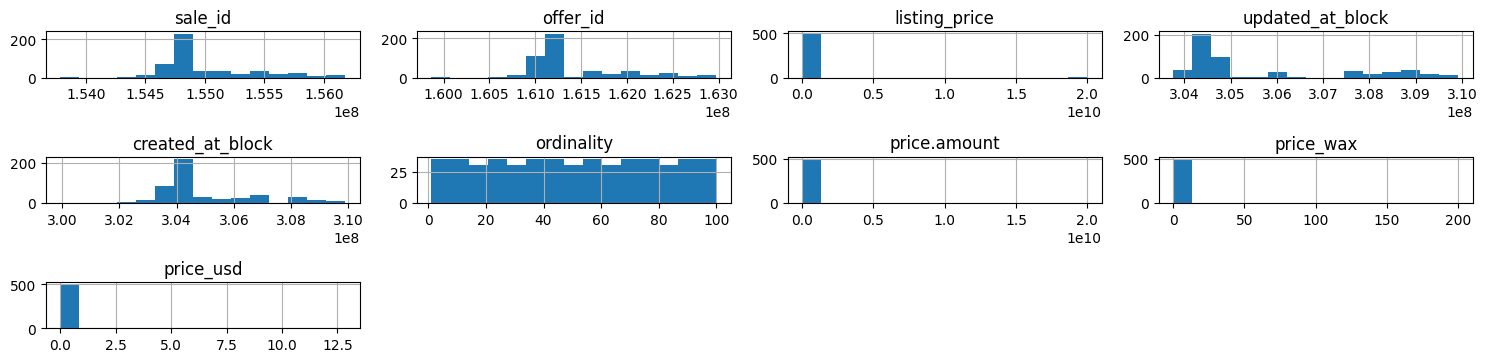

In [335]:
# zobrazenie histogramov numerických dát

numerics = df_of_data.select_dtypes(include='number').columns
print(numerics)
len(numerics)
df_of_data[numerics].hist(bins=15, figsize=(15, 6), layout=(5, 4))
plt.tight_layout()
plt.show()

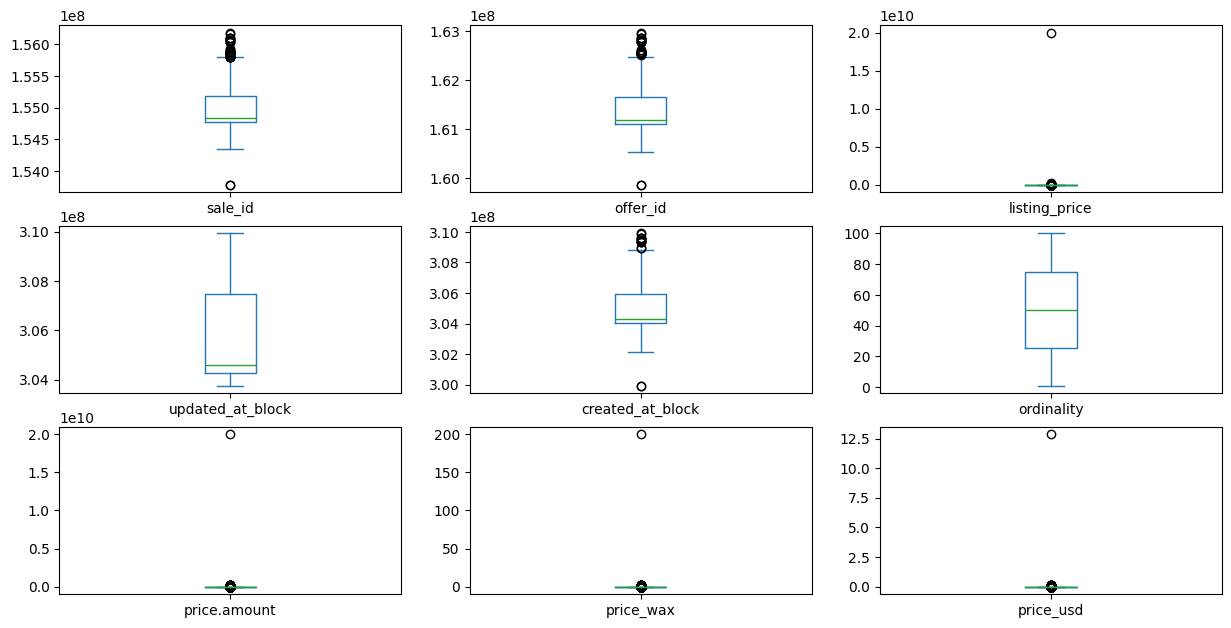

In [336]:
# zobrazenie boxplotov numerických dát
df_of_data[numerics].plot(kind='box', subplots=True, layout=(4, 3), sharex=False, sharey=False, figsize=(15, 10))
plt.show()

In [337]:
# zobrazenie korelačnej matice a výber stĺpcov s koreláciou väčšou ako 0.1
df = df_of_data
df[numerics].corr()
df[numerics].var()[df[numerics].var() > 0.1].index

df[numerics].var()[df[numerics].var() == 0].index
constant_columns = df[numerics].var()[df[numerics].var() == 0].index
print(constant_columns)

Index([], dtype='object')


Index(['sale_id', 'offer_id', 'listing_price', 'updated_at_block',
       'created_at_block', 'ordinality', 'price.amount', 'price_wax',
       'price_usd'],
      dtype='object')


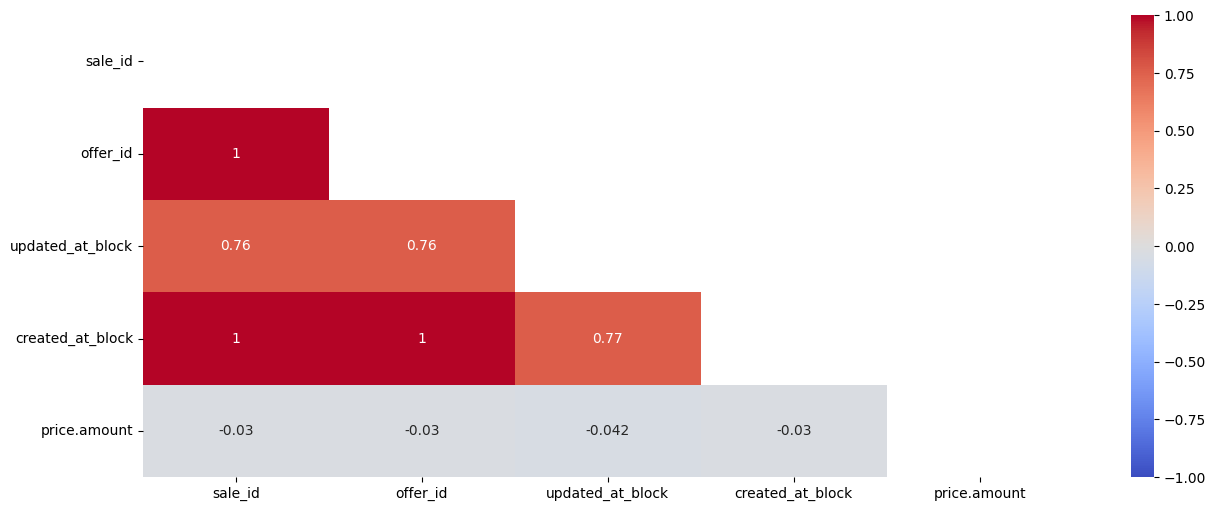

In [338]:
# zobrazenie korelačnej matice

plt.figure(figsize=(15, 6))
numerics = df.select_dtypes(include='number').columns

# vytvorenie korelačnej matice
df_subset_corr = df[numerics].copy()
print(df[numerics].columns)
df_subset_corr.drop(columns=['listing_price', 'ordinality', 'price_wax', 'price_usd'], inplace=True)

corr = df_subset_corr.corr()

#zamaskovanie hornej časti matice
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')  
plt.show()


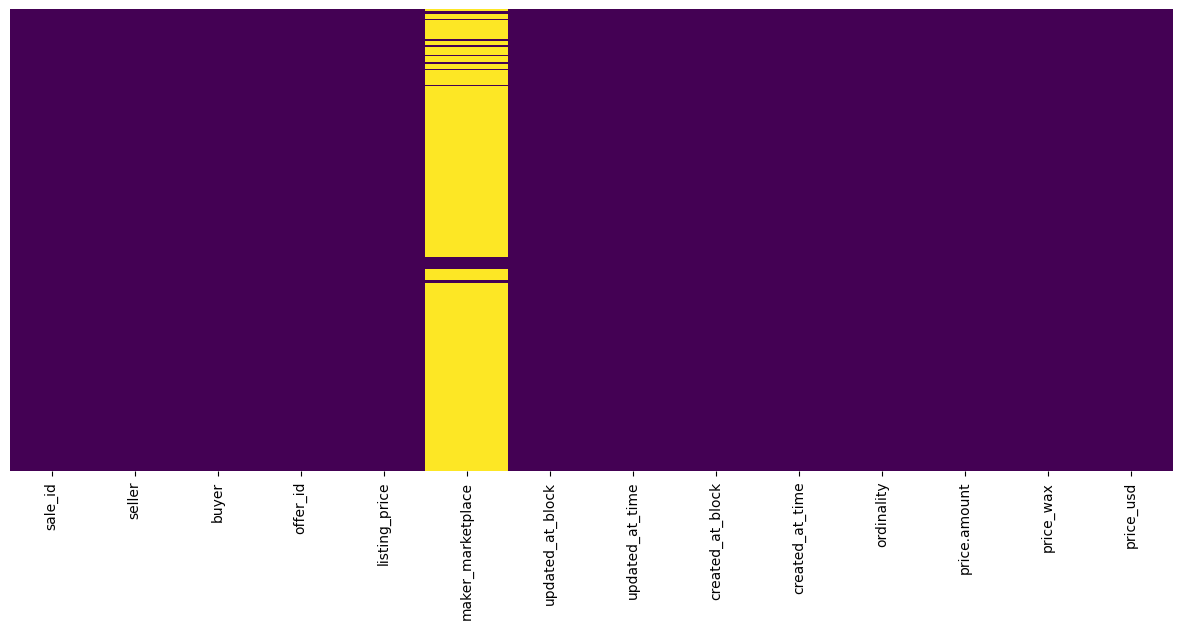

In [339]:
# vizualne zobrazenie dat s prázdnymi hodnotami

plt.figure(figsize=(15, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.yticks([])
plt.show()

In [340]:
rows_count = df.isnull().any(axis=1).sum()
rows_count_without_missing_val = df.shape[0] - rows_count

df_without_missing = df.dropna()    
#df_without_missing = df[~df.isnull().any(axis=1)]
df_with_missing = df[df.isnull().any(axis=1)]

#drop from each column the rows with missing values
df_with_missing.drop(columns='maker_marketplace', inplace=True)
df_without_missing.drop(columns='maker_marketplace', inplace=True)
print(df_with_missing.isnull().any(axis=1).sum())
print(df_without_missing.isnull().any(axis=1).sum())

#df_without_missing.head(rows_count_without_missing_val)


0
0


C:\Users\biank\AppData\Local\Temp\ipykernel_29160\3404596224.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\biank\AppData\Local\Temp\ipykernel_29160\3404596224.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Isolation forest

In [341]:
from sklearn.ensemble import IsolationForest

def izolacnyles(data, contamination=0.1):
    # detekcia anomálií pomocou algoritmu Isolation Forest
    # parametre: data - numerické dáta,
    #            contamination - pomer odhadovaných anomálií v dátach
    # vystupom je zoznam indexov anomálií
    
    model = IsolationForest(n_estimators=100, contamination=0.1, random_state=44)   
    model.fit(data)
    outliers = model.predict(data)
    return outliers

data = df_of_data[["price.amount"]].values
df_isolation_1 = df_of_data.copy()
df_isolation_1['outlier'] = izolacnyles(data)
print(df_isolation_1['outlier'].value_counts())

# zobrazenie anomálií
anomalies = df_isolation_1[df_isolation_1['outlier'] == -1]     # -1 znamená anomáliu
anomalies
print(len(anomalies))


outlier
 1    450
-1     50
Name: count, dtype: int64
50


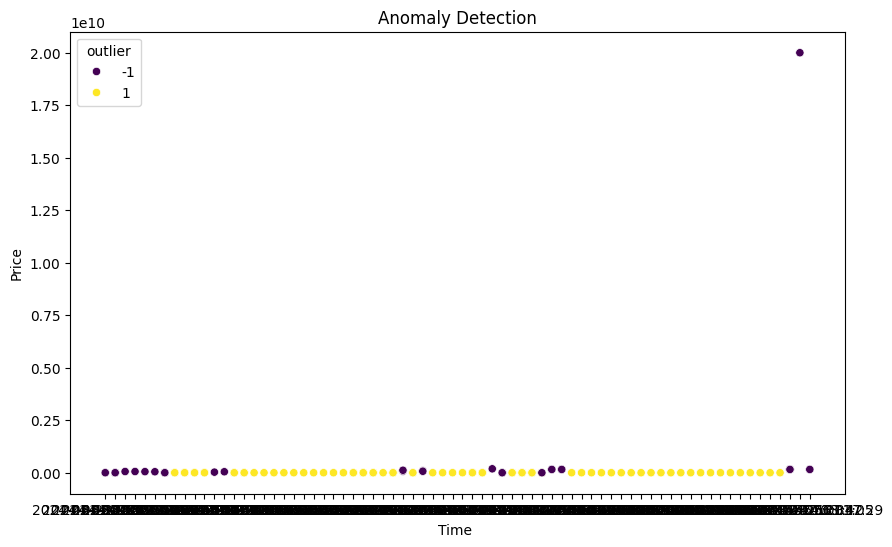

In [342]:
# zobrazenie scatterplotu s anomáliami
plt.figure(figsize=(10, 6))
sns.scatterplot(x='updated_at_time', y='price.amount', hue='outlier', data=df_isolation_1, palette='viridis')
plt.xlabel('Time ')
plt.ylabel('Price')
plt.title('Anomaly Detection')
plt.show()

nasleduju rozne variacie isolation forest a ich zobrazenia

(5, 4)
     updated_at_block  created_at_block  price.amount  outlier
12          309285578         307120080      59900000       -1
16          309245634         299941074       5000000       -1
22          309187430         299941074       5000000       -1
144         305974499         305901053     120000000       -1
497         303909189         303892018   20000000000       -1


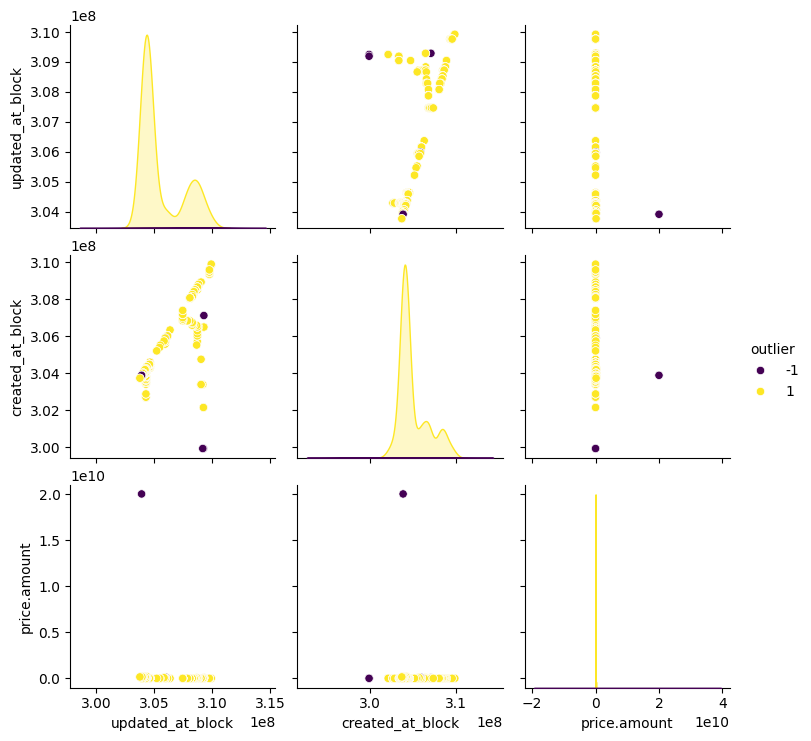

In [343]:
# pristupenie len ku subsetu numerickych stlpcov

from sklearn.ensemble import IsolationForest

df_isolation_2 = df[numerics].copy()
df_isolation_2.drop(columns=['offer_id', 'sale_id', 'listing_price', 'ordinality', 'price_wax', 'price_usd'], inplace=True)

isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=44)

isolation_forest.fit(df_isolation_2)

outliers = isolation_forest.predict(df_isolation_2)

df_isolation_2['outlier'] = outliers

anomalies = df_isolation_2[df_isolation_2['outlier'] == -1] # -1 indicates an outlier

print(anomalies.shape)
print(anomalies)

#pairplot 
sns.pairplot(df_isolation_2, hue='outlier', palette='viridis')
plt.show()

In [346]:
# pristup ku datam a vytvorenie stlpca time_diff

from sklearn.ensemble import IsolationForest

df_isolation_3 = df_of_data.copy()

df_isolation_3['updated_at_time'] = pd.to_datetime(df_isolation_3['updated_at_time'])
df_isolation_3['created_at_time'] = pd.to_datetime(df_isolation_3['created_at_time'])
df_isolation_3['time_diff'] = df_isolation_3['updated_at_time'] - df_isolation_3['created_at_time']

# prevod stlpca time_diff na sekundy
df_isolation_3['time_diff_sec'] = df_isolation_3['time_diff'].dt.total_seconds()

model = IsolationForest(contamination=0.01)  

model.fit(df_isolation_3[['price.amount', 'time_diff_sec']])

df_isolation_3['anomaly'] = model.predict(df_isolation_3[['price.amount', 'time_diff_sec']])

anomalies = df_isolation_3[df_isolation_3['anomaly'] == -1]
anomalies

,sale_id,seller,buyer,offer_id,listing_price,maker_marketplace,updated_at_block,updated_at_time,created_at_block,created_at_time,ordinality,price.amount,price_wax,price_usd,time_diff,time_diff_sec,anomaly
16,153782811,s1.iq.wam,22z2i.c.wam,159865267,5000000,NaN,309245634,2024-05-19 07:24:14,299941074,2024-03-26 10:02:21,17,5000000,0.05,0.00322,53 days 21:21:53,4656113.0,-1
22,153782810,s1.iq.wam,22z2i.c.wam,159865266,5000000,NaN,309187430,2024-05-18 23:19:12,299941074,2024-03-26 10:02:21,23,5000000,0.05,0.00322,53 days 13:16:51,4627011.0,-1
497,154749451,ds3jy.wam,3.g2c.c.wam,161074404,20000000000,NaN,303909189,2024-04-18 10:11:05,303892018,2024-04-18 07:48:00,98,20000000000,200.00,12.86000,0 days 02:23:05,8585.0,-1


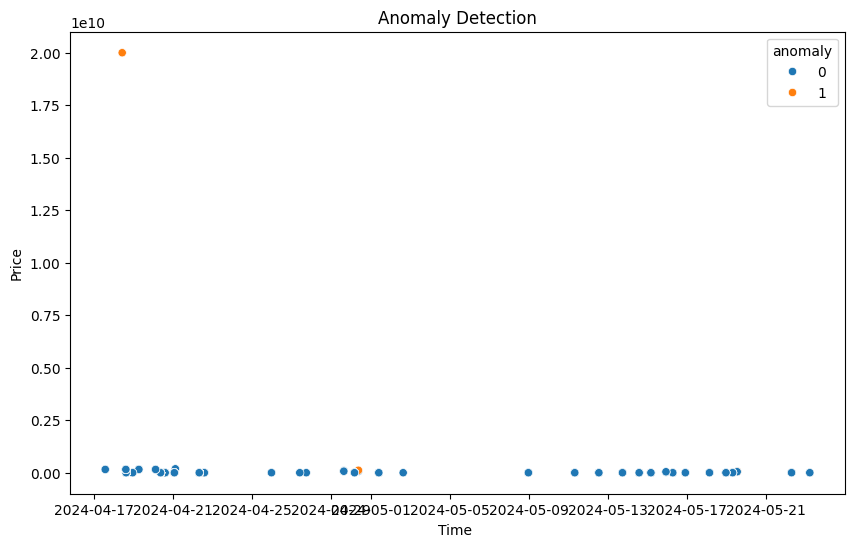

    market_contract assets_contract    sale_id       seller         buyer  \
12     atomicmarket    atomicassets  155483848  qzi2k.c.wam  toonnueadeaw   
13     atomicmarket    atomicassets  155336952    qzcio.wam  toonnueadeaw   
14     atomicmarket    atomicassets  155336627    l3jzs.wam  toonnueadeaw   
144    atomicmarket    atomicassets  155178886  qzi2k.c.wam  toondeawnuea   
497    atomicmarket    atomicassets  154749451    ds3jy.wam   3.g2c.c.wam   

      offer_id  listing_price listing_symbol maker_marketplace  \
12   162042427       59900000            WAX               NaN   
13   161849058       59900000            WAX               NaN   
14   161848725       54900000            WAX               NaN   
144  161660150      120000000            WAX               NaN   
497  161074404    20000000000            WAX               NaN   

     taker_marketplace  ... collection.allow_notify  \
12                 NaN  ...                    True   
13                 NaN  ...   

In [348]:
# trenovanie modelu na základe ceny a času

from sklearn.ensemble import IsolationForest

df_isolation_4 = pd.read_csv('concated_2_farmersworld_data.csv')
df_isolation_4['updated_at_time'] = pd.to_datetime(df_isolation_4['updated_at_time'])
df_isolation_4['created_at_time'] = pd.to_datetime(df_isolation_4['created_at_time'])

reference_point = df_isolation_4['updated_at_time'].min()

df_isolation_4['time'] = (df_isolation_4['updated_at_time'] - reference_point).dt.total_seconds()

model = IsolationForest(contamination=0.01)

model.fit(df_isolation_4[['price.amount', 'time']]) 

df_isolation_4['anomaly'] = model.predict(df_isolation_4[['price.amount', 'time']])
df_isolation_4['anomaly'] = df_isolation_4['anomaly'].map({1: 0, -1: 1})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='updated_at_time', y='price.amount', hue='anomaly', data=df_isolation_4)
plt.xlabel('Time ')
plt.ylabel('Price')
plt.title('Anomaly Detection')
plt.show()


print(df_isolation_4[df_isolation_4['anomaly'] == 1])
print("number of anomalies", df_isolation_4['anomaly'].value_counts())
print("percentage of anomalies", df_isolation_4['anomaly'].value_counts(normalize=True))

interaktivne zobrazenie dat

In [349]:
import nbformat
import plotly.express as px
import pandas as pd

df = pd.read_csv('concated_2_farmersworld_data.csv')

fig = px.scatter(df, x='created_at_time', y='price.amount',
                 hover_data=['buyer', 'seller', 'updated_at_time'],
                 title='WAX Blockchain Transactions')

fig.show()